In [30]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random


from numpy import random
from sklearn.preprocessing import OrdinalEncoder
from IPython import display


#tf.compat.v1.disable_eager_execution()

#%matplotlib inline
random.seed(246)

In [31]:
from Preparation import *
df, cols = prep_data()

In [32]:
split_train_ratio = 0.6
max_journ_len = 16 #as specified in prep_data.jpynb
# Changeable Hyperparameters
num_epochs = 30
lr = 0.01
batch_size = 128
layer1size = 64
layer2size = 64
loss = 'sparse_categorical_crossentropy'
#'mean_squared_error'
# 'binary_crossentropy'
# 'sparse_categorical_crossentropy'


In [33]:
# Dividing the dataset into test and training data
journeys = df['journey_id'].unique()
num_train_samples = int(len(journeys) * split_train_ratio)
shuffled_journeys = np.random.permutation(journeys)
df_train = df[df['journey_id'].isin(shuffled_journeys[:num_train_samples])]
df_test = df[df['journey_id'].isin(shuffled_journeys[num_train_samples:])]

# Next step: transform to tensor

In [34]:
# Transforming the data to three dimensions according to customer journey
X_test, Y_test = mta2tensor(df_test, max_journ_len)
X_train, Y_train = mta2tensor(df_train, max_journ_len)


In [35]:
# Transforming data into tensor and batches
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(batch_size)

In [36]:
print('Size training data : ', len(X_train), '\nSize test data: ', len(X_test))

Size training data :  1020 
Size test data:  680


In [37]:
# Defining some needed input values
time_steps = max_journ_len
input_dim = df_train.shape[1] - 2  # -2 weil journey_id und transaction wegfällt
num_classes = 2 # 1 for binary_loss and mse, 2 for sparse_categorical

# The Models

In [38]:
import keras
from Keras_GRU import *

In [39]:
# to log train and test loss during training
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_losses = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.test_losses.append(logs.get('val_loss'))

## LSTM network

In [40]:
# LSTM Model for comparison
modelLSTM = keras.Sequential()

modelLSTM.add(
    tf.keras.layers.LSTM(units = layer1size, input_shape=(time_steps, input_dim),
    return_sequences=True,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False
    )
)
modelLSTM.add(
    tf.keras.layers.LSTM(units = layer2size,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    time_major=False
    )
)

modelLSTM.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [41]:
modelLSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)

# Create instances of the custom callback
loss_history_LSTM = LossHistory()

# Train the model with the custom callback
modelLSTM.fit(train_dataset, epochs=num_epochs, batch_size=batch_size, validation_data=test_dataset, callbacks=[loss_history_LSTM])

Epoch 1/30
8/8 [==============================] - 5s 162ms/step - loss: 3.0413 - val_loss: 1.9959
Epoch 2/30
8/8 [==============================] - 0s 29ms/step - loss: 0.5058 - val_loss: 0.7168
Epoch 3/30
8/8 [==============================] - 0s 31ms/step - loss: 0.8159 - val_loss: 0.7085
Epoch 4/30
8/8 [==============================] - 0s 32ms/step - loss: 0.7745 - val_loss: 0.6349
Epoch 5/30
8/8 [==============================] - 0s 32ms/step - loss: 0.6748 - val_loss: 0.6185
Epoch 6/30
8/8 [==============================] - 0s 31ms/step - loss: 0.5820 - val_loss: 0.5707
Epoch 7/30
8/8 [==============================] - 0s 31ms/step - loss: 0.5460 - val_loss: 0.5474
Epoch 8/30
8/8 [==============================] - 0s 32ms/step - loss: 0.5366 - val_loss: 0.5599
Epoch 9/30
8/8 [==============================] - 0s 31ms/step - loss: 0.5174 - val_loss: 0.5488
Epoch 10/30
8/8 [==============================] - 0s 33ms/step - loss: 0.5620 - val_loss: 0.5395
Epoch 11/30
8/8 [===========

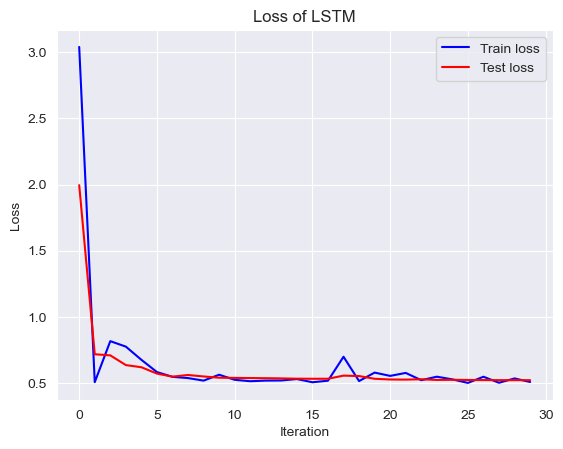

In [42]:
plt.plot(loss_history_LSTM.train_losses, '-b', label='Train loss')
plt.plot(loss_history_LSTM.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of LSTM')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## GRU network
(also uses custom phased GRUCell, but without time gate (time_gate=False))

In [43]:
modelGRU = keras.Sequential()

modelGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer1size, input_shape=(time_steps, input_dim), time_gate=False),
        return_sequences=True,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)
modelGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer2size, time_gate=False),
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)

modelGRU.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [44]:
modelGRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)

# Create instances of the custom callback
loss_history_GRU = LossHistory()

# Train the model with the custom callback

modelGRU.fit(train_dataset, epochs=num_epochs, batch_size=batch_size, validation_data=test_dataset, callbacks=[loss_history_GRU])

Epoch 1/30
Tensor("rnn_4/strided_slice_2:0", shape=(None, 118), dtype=float32)
Tensor("rnn_4/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 118), dtype=float32)
Tensor("rnn_5/strided_slice_2:0", shape=(None, 64), dtype=float32)
Tensor("rnn_5/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 64), dtype=float32)
Tensor("sequential_4/rnn_4/strided_slice_2:0", shape=(None, 118), dtype=float32)
Tensor("sequential_4/rnn_4/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 118), dtype=float32)
Tensor("sequential_4/rnn_5/strided_slice_2:0", shape=(None, 64), dtype=float32)
Tensor("sequential_4/rnn_5/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 64), dtype=float32)
Tensor("sequential_4/rnn_4/strided_slice_2:0", shape=(None, 118), dtype=float32)
Tensor("sequential_4/rnn_4/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 118), dtype=float32)
Tensor("sequential_4/rnn_5/strided_slice_2:0", shape=(None, 64), dtype=float32)
Tensor("sequential_4/rnn_

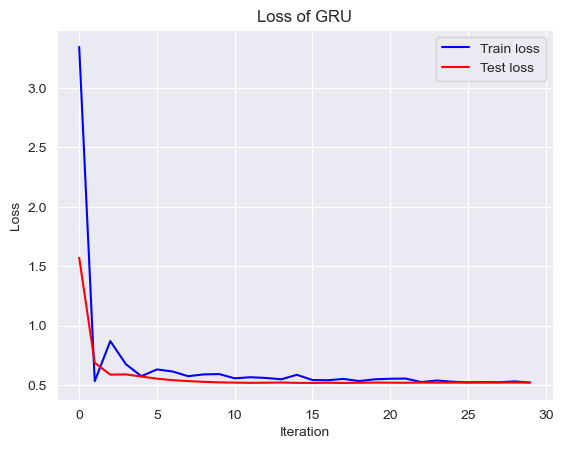

In [45]:
plt.plot(loss_history_GRU.train_losses, '-b', label='Train loss')
plt.plot(loss_history_GRU.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of GRU')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## DIY phased GRU

In [46]:
modelphasedGRU = keras.Sequential()

modelphasedGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer1size, input_shape=(time_steps, input_dim), time_gate=True),
        return_sequences=True,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)
modelphasedGRU.add(
    tf.keras.layers.RNN(
        phased_GRUCell(units = layer2size, time_gate=False),
        return_sequences=False,
        return_state=False,
        go_backwards=False,
        stateful=False,
        unroll=False,
        time_major=False
    )
)

modelphasedGRU.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [47]:
modelphasedGRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss)

# Create instances of the custom callback
loss_history_phasedGRU = LossHistory()

# Train the model with the custom callback

modelphasedGRU.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, callbacks=[loss_history_phasedGRU])

Epoch 1/30
Tensor("rnn_6/phased_gru_cell_6/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("rnn_6/while/phased_gru_cell_6/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("rnn_7/strided_slice_2:0", shape=(None, 64), dtype=float32)
Tensor("rnn_7/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 64), dtype=float32)
Tensor("sequential_5/rnn_6/phased_gru_cell_6/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_5/rnn_6/while/phased_gru_cell_6/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_5/rnn_7/strided_slice_2:0", shape=(None, 64), dtype=float32)
Tensor("sequential_5/rnn_7/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 64), dtype=float32)
Tensor("sequential_5/rnn_6/phased_gru_cell_6/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_5/rnn_6/while/phased_gru_cell_6/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_5/rnn_7/strided_slice_2:0", shape=(None, 64), dtyp

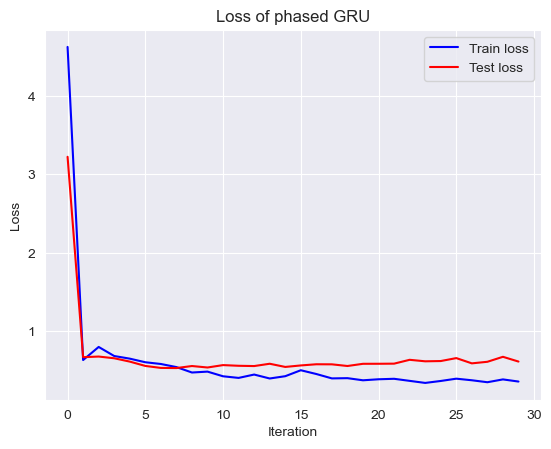

In [48]:
plt.plot(loss_history_phasedGRU.train_losses, '-b', label='Train loss')
plt.plot(loss_history_phasedGRU.test_losses, '-r', label='Test loss')
plt.legend(loc=0)
plt.title('Loss of phased GRU')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Comparison of models

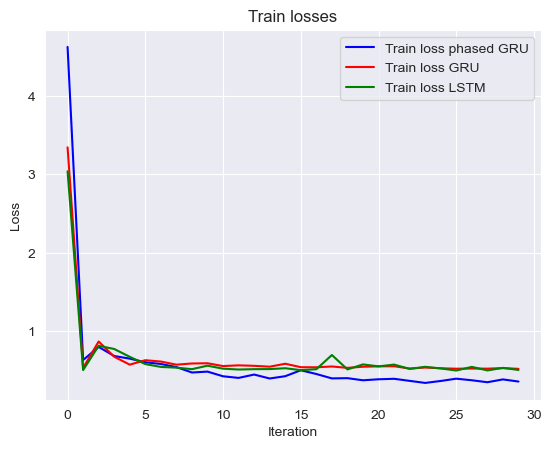

In [49]:
plt.plot(loss_history_phasedGRU.train_losses, '-b', label='Train loss phased GRU')
plt.plot(loss_history_GRU.train_losses, '-r', label='Train loss GRU')
plt.plot(loss_history_LSTM.train_losses, '-g', label='Train loss LSTM')
plt.legend(loc=0)
plt.title('Train losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig('TrainingLosses_lossfct{}_lr{}_bs{}_l1s{}_l2s{}.png'.format(loss,lr,batch_size,layer1size,layer2size))
plt.show()

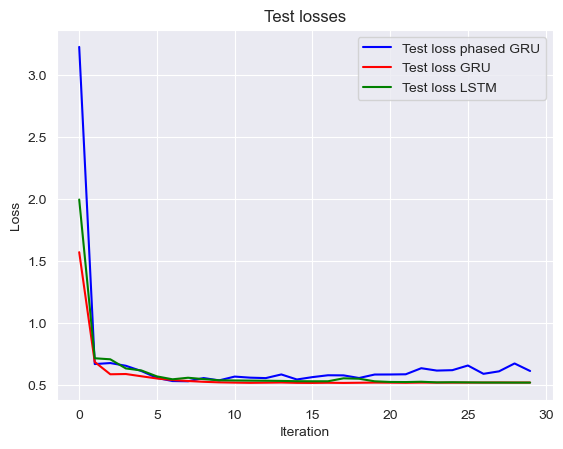

In [50]:
plt.plot(loss_history_phasedGRU.test_losses, '-b', label='Test loss phased GRU')
plt.plot(loss_history_GRU.test_losses, '-r', label='Test loss GRU')
plt.plot(loss_history_LSTM.test_losses, '-g', label='Test loss LSTM')
plt.legend(loc=0)
plt.title('Test losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.show()
plt.savefig('TestLosses_lossfct{}_lr{}_bs{}_l1s{}_l2s{}.png'.format(loss,lr,batch_size,layer1size,layer2size))


In [51]:
modelGRU.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_4 (RNN)                 (None, 16, 64)            35328     
                                                                 
 rnn_5 (RNN)                 (None, 64)                24960     
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 60,418
Trainable params: 60,418
Non-trainable params: 0
_________________________________________________________________


In [52]:
modelphasedGRU.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_6 (RNN)                 (None, 16, 64)            35270     
                                                                 
 rnn_7 (RNN)                 (None, 64)                24960     
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 60,360
Trainable params: 60,360
Non-trainable params: 0
_________________________________________________________________


In [53]:
modelLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 16, 64)            46848     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 80,002
Trainable params: 80,002
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Save optimized model after Hyperparametertuning
#modelGRU.save('GRUmodel')
#modelphasedGRU.save('phasedGRUmodel')
#reloaded_modelGRU = tf.keras.models.load_model('GRUmodel')
#reloaded_modelphasedGRU = tf.keras.models.load_model('phasedGRUmodel')

In [55]:
# evaluate accuracy??
modelLSTM.evaluate(test_dataset)
modelGRU.evaluate(test_dataset)
modelphasedGRU.evaluate(test_dataset)

6/6 [==============================] - 0s 18ms/step - loss: 0.6143


0.6143375039100647

In [56]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score


In [57]:
#all based on sparse_categorical_crossentropy loss and two classes
y_pred_lstm = modelLSTM.predict(X_test)
y_pred_gru = modelGRU.predict(X_test)
y_pred_phasedgru = modelphasedGRU.predict(X_test)

22/22 [==============================] - 1s 6ms/step
Tensor("sequential_4/rnn_4/strided_slice_2:0", shape=(None, 118), dtype=float32)
Tensor("sequential_4/rnn_4/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 118), dtype=float32)
Tensor("sequential_4/rnn_5/strided_slice_2:0", shape=(None, 64), dtype=float32)
Tensor("sequential_4/rnn_5/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 64), dtype=float32)
22/22 [==============================] - 1s 10ms/step
Tensor("sequential_5/rnn_6/phased_gru_cell_6/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_5/rnn_6/while/phased_gru_cell_6/strided_slice:0", shape=(None, 117), dtype=float32)
Tensor("sequential_5/rnn_7/strided_slice_2:0", shape=(None, 64), dtype=float32)
Tensor("sequential_5/rnn_7/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None, 64), dtype=float32)
22/22 [==============================] - 1s 11ms/step


In [58]:
auc_lstm = roc_auc_score(Y_test, y_pred_lstm[:,1])
auc_gru = roc_auc_score(Y_test, y_pred_gru[:,1])
auc_phasedgru = roc_auc_score(Y_test, y_pred_phasedgru[:,1])
print('AUC for LSTM: {}\nAUC for GRU: {}\nAUC for phased_GRU: {}'.format(auc_lstm,auc_gru,auc_phasedgru))

AUC for LSTM: 0.7959567161277781
AUC for GRU: 0.7969471725708361
AUC for phased_GRU: 0.7680573168812657


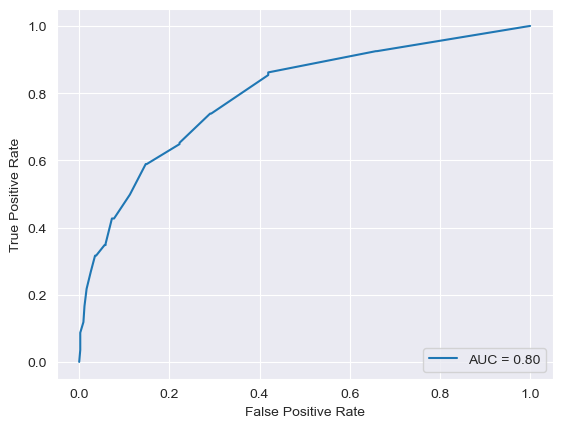

In [59]:
fpr, tpr, _ = roc_curve(Y_test, y_pred_lstm[:,1])
plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_lstm)
#plt.title('ROC of LSTM')
plt.plot()

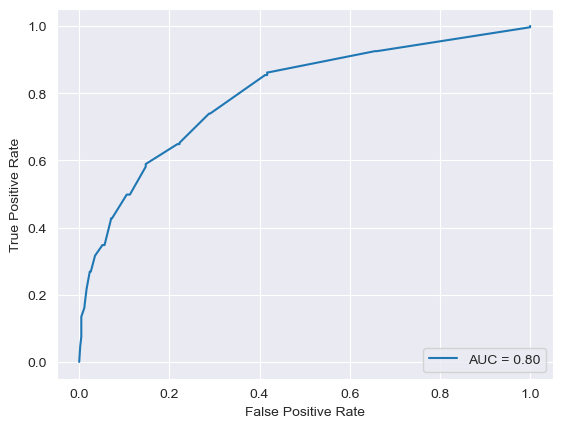

In [60]:
fpr, tpr, _ = roc_curve(Y_test, y_pred_gru[:,1])
plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_gru)
#plt.title('ROC of GRU')
plt.plot()

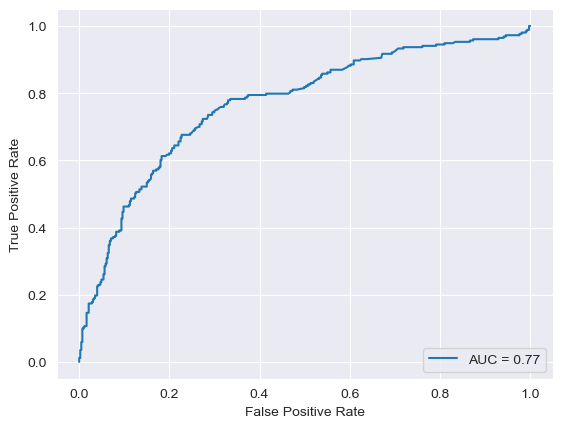

In [61]:
fpr, tpr, _  = roc_curve(Y_test, y_pred_phasedgru[:,1])
plt = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_phasedgru)
#plt.title('ROC of phasedGRU')
plt.plot()

# Explanations


In [62]:
# predict
pred = modelLSTM.predict(X_test)

22/22 [==============================] - 0s 7ms/step


In [63]:
pred[:,0]

array([0.92252356, 0.8335522 , 0.8335522 , 0.92252356, 0.8335522 ,
       0.6293136 , 0.92252356, 0.8335522 , 0.92252356, 0.8335522 ,
       0.92252356, 0.8335522 , 0.8335522 , 0.48520035, 0.8335522 ,
       0.8335522 , 0.92252356, 0.20233846, 0.8335522 , 0.6293136 ,
       0.50883955, 0.53749037, 0.92252356, 0.92252356, 0.92252356,
       0.50883955, 0.92252356, 0.8335522 , 0.92252356, 0.6293136 ,
       0.53749037, 0.92252356, 0.92252356, 0.53749037, 0.28049964,
       0.92252356, 0.8335522 , 0.8335522 , 0.48520035, 0.92252356,
       0.92252356, 0.92252356, 0.8335522 , 0.8335522 , 0.8335522 ,
       0.4046534 , 0.6293136 , 0.8335522 , 0.8335522 , 0.92252356,
       0.8335522 , 0.34210446, 0.50883955, 0.53749037, 0.43743294,
       0.53749037, 0.8335522 , 0.8335522 , 0.8335522 , 0.6293136 ,
       0.92252356, 0.8335522 , 0.8335522 , 0.92252356, 0.92252356,
       0.6293136 , 0.50883955, 0.92252356, 0.6293136 , 0.8335522 ,
       0.43743294, 0.8335522 , 0.92252356, 0.92252356, 0.20233

In [64]:
# is prediction 1?
print('expected outcome test: ', sum(Y_test)/len(Y_test), '\nexpected outcome train: ',sum(Y_train)/len(Y_train))

expected outcome test:  0.3720588235294118 
expected outcome train:  0.34509803921568627


In [65]:
import shap
from keras import utils
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [66]:
x_train = tf.convert_to_tensor(X_train)

In [67]:
x_test = tf.convert_to_tensor(X_test)

In [68]:

#keras.utils.plot_model(modelLSTM, "my_first_model_with_shape_info.png", show_shapes=True)


In [69]:
x_test[0:3].shape

TensorShape([3, 16, 118])

In [70]:
#tf.compat.v1.disable_v2_behavior()


In [71]:
#from tensorflow.compat.v1.keras.backend import get_session
#tf.compat.v1.disable_v2_behavior()


#explainer = shap.DeepExplainer(modelLSTM.call(inputs=x_test ,training=False), data=test_dataset)
#shap_values = explainer.shap_values(x_test[0:3])

In [72]:
#shap_values = explainer.shap_values(x_test[:100])

In [73]:
#shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[1], x_test[0:3])

In [74]:
#shap.summary_plot(shap_values,x_test)
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0,:]  ,x_test[0,:])